<a href="https://colab.research.google.com/github/sarthak-srivastava/Denoising_Of_Images/blob/master/Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import keras.datasets.cifar10 as cf10

In [41]:
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, ReLU, Concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [42]:
(train_x, train_y), (test_x, test_y) = cf10.load_data()
train_x = train_x.astype('float32')/255 # Normalize the data points
test_x = test_x.astype('float32')/255

In [43]:
train_x[0].shape  # dimensions of a single image

(32, 32, 3)

In [73]:
def noising_and_clipping(data):
   noise = np.random.normal(loc=0.0, scale=0.2, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
   
train_data_noisy = noising_and_clipping(train_x)
test_data_noisy = noising_and_clipping(test_x)

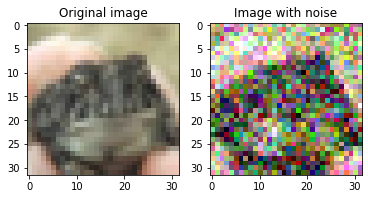

In [74]:
idx = 25
plt.subplot(1,2,1)
plt.imshow(train_x[idx])
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(train_data_noisy[idx])
plt.title('Image with noise')
plt.show()

In [46]:
# Now we have noisy data + Clean data. We can come up with something to train a model to clean up the image noise.

In [47]:
# Enter Auto Encoder. We are aiming to convolve the image pixels into lower dimensional space, from where on we can start reconstructing the image in such a way that noise part 
# is skipped out of the final output image. Training the model with above generate input-output pair can help us with that.

In [48]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [68]:

def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 128, 3, 1)
   deconv_block1 = deconv_block(conv_block4, 128, 3)
   merge1 = Concatenate()([deconv_block1, conv_block2])
   deconv_block2 = deconv_block(merge1, 64, 3)
   merge2 = Concatenate()([deconv_block2, conv_block1])
   deconv_block3 = deconv_block(merge2, 32, 3)
   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block3)
   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='dae')

In [69]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
       train_x,
       validation_data=(test_data_noisy, test_x),
       epochs=1,
       batch_size=256,
       callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 293s 6ms/step - loss: 0.0060 - val_loss: 0.0248

Epoch 00001: val_loss improved from inf to 0.02477, saving model to model.h5


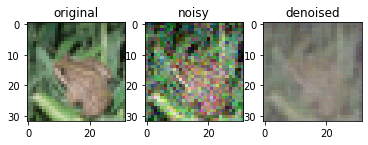

In [70]:
dae.load_weights('model.h5')
test_data_denoised = dae.predict(test_data_noisy)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

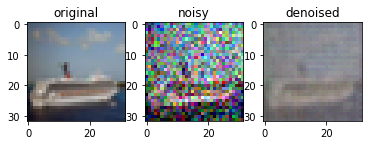

In [76]:
idx = 73
plt.subplot(1,3,1)
plt.imshow(test_x[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()